In [99]:
import pandas as pd
import numpy as np
import os 
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns  

In [24]:
file_list = os.listdir("project-20-files")
dataframes = {}
for file_name in file_list:
    file_path = os.path.join("project-20-files", file_name) 
    df_name = os.path.splitext(file_name)[0]  
    dataframes[df_name] = pd.read_csv(file_path)


dep = pd.read_csv("project-20-files/departments.csv")
reg = pd.read_csv("project-20-files/regions.csv")

In [25]:
# Identify DataFrames related to learning
learn_dataframes = {key: df for key, df in dataframes.items() if "learn" in key.lower()}

# Check for missing values in each DataFrame before merging
for name, df in learn_dataframes.items():
    if df.isnull().values.any():
        print(f"DataFrame '{name}' contains missing values.")
    else:
        print(f"DataFrame '{name}' has no missing values.")

# Identify DataFrames related to testing
test_dataframes = {key: df for key, df in dataframes.items() if "test" in key.lower()}

# Check for missing values in each DataFrame before merging
for name, df in test_dataframes.items():
    if df.isnull().values.any():
        print(f"DataFrame '{name}' contains missing values.")
    else:
        print(f"DataFrame '{name}' has no missing values.")




DataFrame 'learn_dataset' has no missing values.
DataFrame 'learn_dataset_emp_type' has no missing values.
DataFrame 'learn_dataset_job' contains missing values.
DataFrame 'learn_dataset_retired_former' has no missing values.
DataFrame 'learn_dataset_retired_jobs' contains missing values.
DataFrame 'learn_dataset_retired_pension' has no missing values.
DataFrame 'learn_dataset_sport' has no missing values.
DataFrame 'test_dataset' has no missing values.
DataFrame 'test_dataset_emp_type' has no missing values.
DataFrame 'test_dataset_job' contains missing values.
DataFrame 'test_dataset_retired_former' has no missing values.
DataFrame 'test_dataset_retired_jobs' contains missing values.
DataFrame 'test_dataset_retired_pension' has no missing values.
DataFrame 'test_dataset_sport' has no missing values.


In [26]:
learn_dataframes = {key: df for key, df in dataframes.items() if "learn" in key.lower()}

merged_training = None

for name, df in learn_dataframes.items():
    if merged_training is None:
        # Use the first DataFrame as the base
        merged_training = df
    else:
        # Merge with the next DataFrame
        merged_training = pd.merge(merged_training, df, on="pkey", how="outer")

test_dataframes = {key: df for key, df in dataframes.items() if "test" in key.lower()}

merged_test = None

for name, df in test_dataframes.items():
    if merged_test is None:
        # Use the first DataFrame as the base
        merged_test = df
    else:
        # Merge with the next DataFrame
        merged_test = pd.merge(merged_test, df, on="pkey", how="outer")

In [27]:
# Filter dataframes that contain "city" in their key
city_dataframes = {key: df for key, df in dataframes.items() if "city" in key.lower()}

# Initialize the merged DataFrame
merged_city = None

# Loop through the filtered DataFrames and merge them on 'INSEE'
for name, df in city_dataframes.items():
    if merged_city is None:
        # Use the first DataFrame as the base
        merged_city = df
    else:
        # Merge with the next DataFrame on the 'INSEE' column
        merged_city = pd.merge(merged_city, df, on="INSEE", how="outer")

By checking which dataframes has missing values we can see that only retired_jobs and and jobs have missing values. This is obviously potentially problematic but it still allows us to merge the all datasets since we can still identify these missing values conditioning on activity type. By merging the data we introduce a lot of "missing" values that are in fact logically missing. A retired person will not have a salary and a working person will not take out retirement pension. This is therefore addressed by introducing the category "not_relevant" (in lack of a better term) for categorical variables and zeros for numerical; in cases where that makes sense. For retirement age we opted for "not_relevant". The same overall logic is also applied in the inverse case for people that are outside the workforce and thus lack work related data. 

A somewhat unique group of 251 individuals is the individuals with occupation code csp_8_5 and csp_8_6 which are considered retired but in all likelihood never worked either. It seem to either old housewifes or institutionalized individuals for instance. For these we introduce "never worked" for related columns.

More interestingly, if you beling the the emp_type starting with ec-2 your are not employed (independent or employeur for instance) and will therefore also lack data related to those columns. We where able to map ec-2-1 to the employer_type "ct_6", and ec-2-2, ec-2-3 to "ct_9". For all ec-2 it is also reasoanable possible to say that they belong to "work_condition" = N. Using a combination of work_desc and emp_type we were also able to say something about the employer count, if you are an categorised some ec-2-1 you will belong to the employee_count = tr_1 as an example. We introduced "no contract" to the ec-2 groups and also drew the conclusion that observations belonging to ec-1-6 with high likelihood have the contract type CDI since there was zero examples of another scenario in the data. This line of reasoning surrounding ec-2 categories could be essentially conducted for most of the missing job, or retirement related variables, depending on status. We introduced a new column "working_nocon_income" for working but non contractual income for this group. Some variables was could not be deducted using this reasoning however, working hours was one of those. We also realised that the Occupation 42 group "csp_4_4" belonged to a group that does not recieve a salary; clergymen(women). This above mentioned logic could therefore be applied to this groups as well. 

In [31]:
def cleaning(data):
    data = pd.merge(data,merged_city,on = "INSEE", how = "inner")
    data = pd.merge(data,dep, on="dep")
    
    
    # not yet eligeable for retirement
    target_activity_types_y = ["TACT1-1", "TACT1-2", "TACT2-2", "TACT2-4", "TACT2-5"]

    # Define the specific columns for retired individuals
    retired_col = ["Previous_occupation_42", "previous_emp_type", "previous_dep", "retirement_pay"]

    # Apply logic to fill NaN values in 'retirement_age' only if activity_type is in target_activity_types_y
    data['retirement_age'] = data.apply(
    lambda row: 'not_relevant' if pd.isna(row['retirement_age']) and row['activity_type'] in target_activity_types_y 
        else row['retirement_age'],
        axis=1)

    # Select columns ending with '_y'
    columns_y = [col for col in data.columns if col.endswith('_y')]

    # Combine the lists of columns to include the retired columns as well
    all_target_columns = columns_y + retired_col
    
    # Loop through the combined list of columns (both '_y' and retired columns)
    for col in all_target_columns:
        # Check if the column exists in data
        if col in data.columns:
            # Check if the column is numerical
            if pd.api.types.is_numeric_dtype(data[col]):
                # For numerical columns, set 0 for matching activity types, keep existing values otherwise
                data[col] = data.apply(
                    lambda row: 0 if row["activity_type"] in target_activity_types_y and pd.isna(row[col]) else row[col],
                    axis=1
                )
            else:
                # For non-numerical columns, set 'not_relevant' for matching activity types
                data[col] = data.apply(
                    lambda row: "not_relevant" if row["activity_type"] in target_activity_types_y and pd.isna(row[col]) else row[col],
                    axis=1
                )
    
    
    
    ## There is a special group of 251 observations that are considered retired but that with most likelihood never worked.
    ## which very likely is people that has never worked due to some reason (old housewifes, institutionalized for instance)
    # this would explain lack of data regarding previous work
    
    
    csp_codes = ["csp_8_5", "csp_8_6"]
    
    # Function to apply the changes
    def fill_missing_values(row):
        # Check if Occupation_42 is one of the csp codes and the columns are NaN
        if row["Occupation_42"] in csp_codes:
            if pd.isna(row["Previous_occupation_42"]):
                row["Previous_occupation_42"] = "never worked"
            if pd.isna(row["previous_emp_type"]):
                row["previous_emp_type"] = "never worked"
            if pd.isna(row["retirement_age"]):
                row["retirement_age"] = "never worked"
        return row
    
    # Apply the function to the DataFrame
    data = data.apply(fill_missing_values, axis=1)
    
    
    
    
    ##
    ## Not working and will therefore not have any values for working related questions. 
    target_activity_types = ["TACT2-1", "TACT1-2","TACT2-2", "TACT2-4", "TACT2-5"]
    
    data.loc[data["activity_type"].isin(target_activity_types) & data["PAY"].isna(), "PAY"] = 0
    data.loc[data["activity_type"].isin(target_activity_types) & data["emp_type"].isna(), "emp_type"] = "not_relevant"
    
    # Select columns ending with '_x'
    columns_x = [col for col in data.columns if col.endswith('_x')]
    
    # Loop through the selected columns
    for col in columns_x:
        # Check if the column is numerical
        if pd.api.types.is_numeric_dtype(data[col]):
            # For numerical columns, set 0 for matching activity types, keep existing values otherwise
            data[col] = data.apply(
                lambda row: 0 if row["activity_type"] in target_activity_types and pd.isna(row[col]) else row[col],
                axis=1
            )
        else:
            # For non-numerical columns, set 'not_relevant' for matching activity types
            data[col] = data.apply(
                lambda row: "not_relevant" if row["activity_type"] in target_activity_types and pd.isna(row[col]) else row[col],
                axis=1
            )
   
    
    ## Sport people are either 
    data.loc[:, "SPORTS"] = data.loc[:, "SPORTS"].fillna("not_registered")


    ###
    data.loc[data['emp_type'].str.startswith('ec-2-1', na=False), 'employer_type_x'] = "ct_6"
    data.loc[data['emp_type'].str.startswith('ec-2-2', na=False), 'employer_type_x'] = "ct_9"
    data.loc[data['emp_type'].str.startswith('ec-2-3', na=False), 'employer_type_x'] = "ct_9"
    
    data.loc[data['previous_emp_type'].str.startswith('ec-2-1', na=False), 'employer_type_y'] = "ct_6"
    data.loc[data['previous_emp_type'].str.startswith('ec-2-2', na=False), 'employer_type_y'] = "ct_9"
    data.loc[data['previous_emp_type'].str.startswith('ec-2-3', na=False), 'employer_type_y'] = "ct_9"


    ###
    data.loc[data['previous_emp_type'].str.startswith('ec-2', na=False), 'work_condition_x'] = "N"
    data.loc[data['previous_emp_type'].str.startswith('ec-2', na=False), 'work_condition_y'] = "N"
    
    ###
    data.loc[data['work_desc_x'].str.startswith('231a', na=False), 'employee_count_x'] = "tr_6"
    data.loc[data['emp_type'].str.startswith('ec-2-1', na=False), 'employee_count_x'] = "tr_1"
    
    data.loc[data['work_desc_y'].str.startswith('231a', na=False), 'employee_count_y'] = "tr_6"
    data.loc[data['previous_emp_type'].str.startswith('ec-2-1', na=False), 'employee_count_y'] = "tr_1"
    
    ###
    data.loc[data['emp_type'].str.startswith('ec-1-6', na=False), 'Type_of_contract_x'] = "CDI"
    data.loc[data['emp_type'].str.startswith('ec-2', na=False), 'Type_of_contract_x'] = "No contract"
    
    data.loc[data['previous_emp_type'].str.startswith('ec-1-6', na=False), 'Type_of_contract_y'] = "CDI"
    data.loc[data['previous_emp_type'].str.startswith('ec-2', na=False), 'Type_of_contract_y'] = "No contract"


    ###
    data.loc[data['emp_type'].str.startswith('ec-2', na=False), 'JOB_CATEGORY_x'] = "not employee"
    data.loc[data['emp_type'].str.startswith('ec-1-6', na=False), 'JOB_CATEGORY_x'] = "O"
    
    data.loc[data['previous_emp_type'].str.startswith('ec-2', na=False), 'JOB_CATEGORY_y'] = "not employee"
    data.loc[data['previous_emp_type'].str.startswith('ec-1-6', na=False), 'JOB_CATEGORY_y'] = "O"

    ###
    data.loc[data['emp_type'].str.startswith('ec-2', na=False), 'PAY'] = 0

    data.loc[data['previous_emp_type'].str.startswith('ec-2', na=False), 'retirement_pay'] = 0


    ###
    data['working_but_nocon_income'] = data['emp_type'].apply(
        lambda x: 1 if str(x).startswith('ec-2') else 0)
        
    
    #priests
    data.loc[
        (data['Occupation_42'] == 'csp_4_4') & data['PAY'].isna(), 
        ['PAY', 'working_but_nocon_income']
    ] = [0, 1]
    
    data.loc[
        (data['Occupation_42'] == 'csp_4_4') & data['employer_type_x'].isna(), "employer_type_x"] = "ct_2" 
    
    #priests retired
    data.loc[
        (data['Previous_occupation_42'] == 'csp_4_4') & data['PAY'].isna(), 
        ['PAY', 'working_but_nocon_income']
    ] = [0, 1]
    
    data.loc[
        (data['Occupation_42'] == 'csp_4_4') & data['employer_type_x'].isna(), "employer_type_x"] = "ct_2" 
    
    
    data = data.drop(["JOB_CATEGORY_x", "JOB_CATEGORY_y"], axis=1)
    
    # Creating a new column 'fixed_contract' based on conditions applied to 'emp_type'
    def assign_fixed_contract(emp_type):
        if emp_type.startswith('ec-1') and emp_type != 'ec-1-6':
            return 'yes'
        elif emp_type == 'ec-1-6':
            return 'no contract'
        else:
            return 'no'
    
    data['fixed_contract'] = data['emp_type'].apply(assign_fixed_contract)
    
    return data 

In [39]:
merged_training = cleaning(merged_training)

In [75]:
merged_training_sampled = merged_training.sample(frac=1, random_state=42)
# Copy the original dataset
df = merged_training_sampled.copy()
label_mapping = {'I': 0, 'N':1}
df['target'] = df['target'].map(label_mapping)
# Separate the target, features, and pkey
X = df.drop(columns=['target'])
y = df['target']

# Handle categorical features using Label Encoding
categorical_cols = X.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col].astype(str))

# Split the dataset into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Stratify based on the target variable
)

Accuracy: 88.39%
Precision: 78.56%
Recall: 87.64%
F1 Score: 82.85%


Text(45.722222222222214, 0.5, 'True')

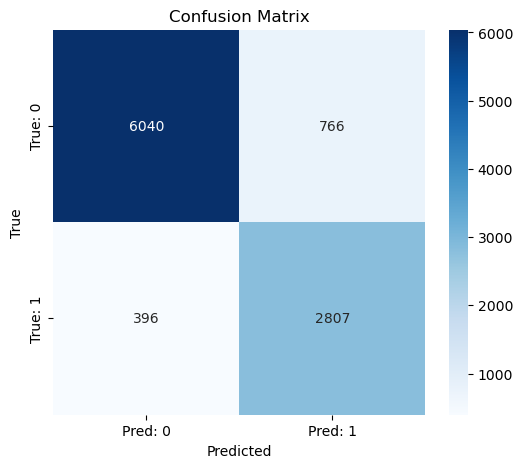

In [101]:
best_random_model = joblib.load('best_xgb_model.pkl')
y_pred_new = best_random_model.predict(X_test)

# You can also compute metrics as before
accuracy = accuracy_score(y_test, y_pred_new)
precision = precision_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new)
f1 = f1_score(y_test, y_pred_new)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')


cm = confusion_matrix(y_test, y_pred_new)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])

# Title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

<Figure size 1000x600 with 0 Axes>

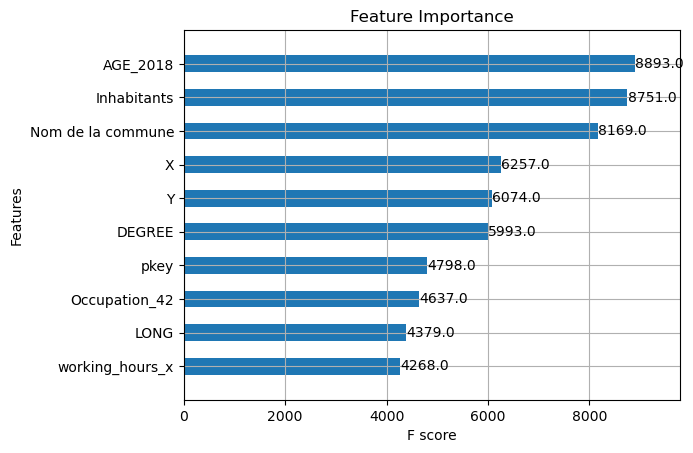

In [103]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_random_model, 
                    importance_type='weight',  # You can change this to 'gain' or 'cover' depending on the measure you want
                    max_num_features=10,  # Limit the number of features to show, change as needed
                    title='Feature Importance',
                    height=0.5)
plt.show()

Accuracy: 78.50%
Precision: 78.30%
Recall: 45.39%
F1 Score: 57.47%


Text(45.722222222222214, 0.5, 'True')

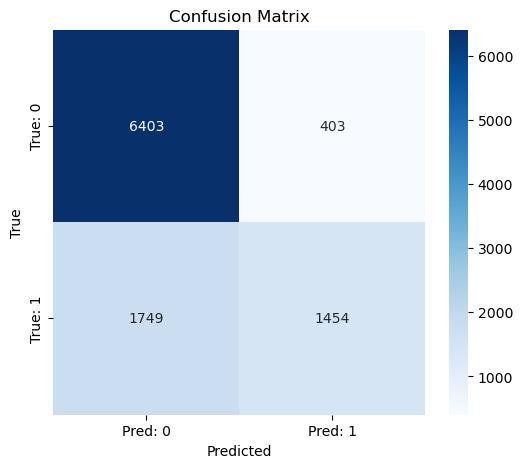

In [113]:
best_rf_model = joblib.load('best_rf_model.pkl')
y_pred_new = best_rf_model.predict(X_test)

# You can also compute metrics as before
accuracy = accuracy_score(y_test, y_pred_new)
precision = precision_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new)
f1 = f1_score(y_test, y_pred_new)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')


cm = confusion_matrix(y_test, y_pred_new)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])

# Title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')